<a href="https://colab.research.google.com/github/lucasnofear/Deep-Learning-with-Python-Practice/blob/Keras-and-Tensorflow/ch5_4_visualize_CNN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Visualize the activation layers of the previous trained cat vs dog Convnet.

In [0]:
from keras.models import load_model

In [0]:
model = load_model('cats_and_dogs_small_2.h5')

In [3]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)      

Preprocessing a single image

In [4]:
img_path = 'cat.11894.jpg'

from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

print(img_tensor.shape)

(1, 150, 150, 3)


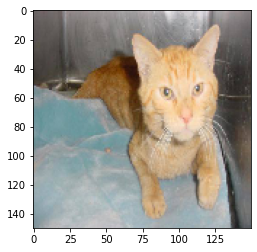

In [5]:
# display the test picture
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [0]:
# extract the output of the top eight layers
from keras import models
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [0]:
activations = activation_model.predict(img_tensor)

In [8]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


First layer has 32 channels. Next visualize individual channel output

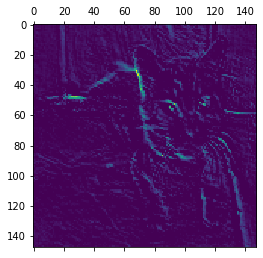

In [9]:
plt.matshow(first_layer_activation[0,:,:,4], cmap='viridis')

This channel appears to encode edge detector.

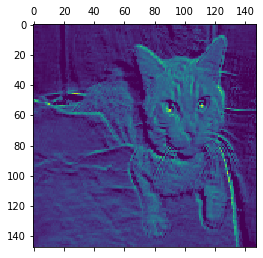

In [10]:
plt.matshow(first_layer_activation[0,:,:,7], cmap='viridis')

This channel appears to detect depth.

Next, visualize every channel in every intermediate activation.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


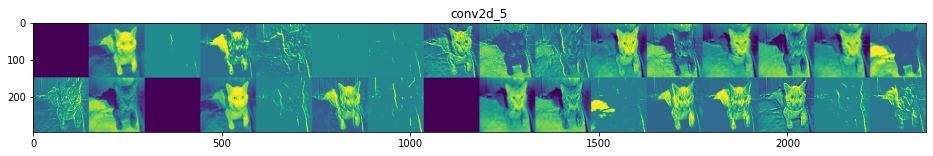

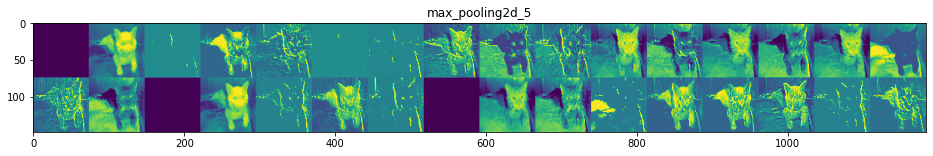

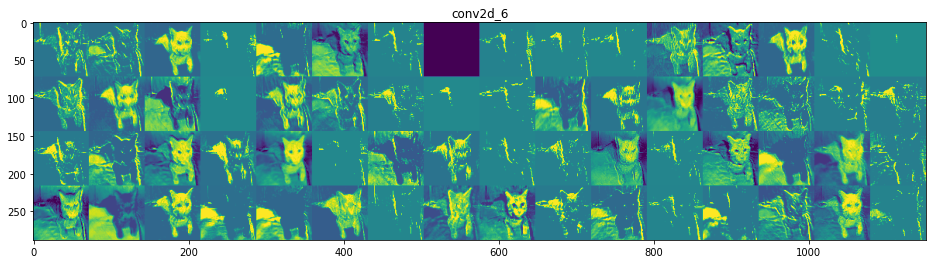

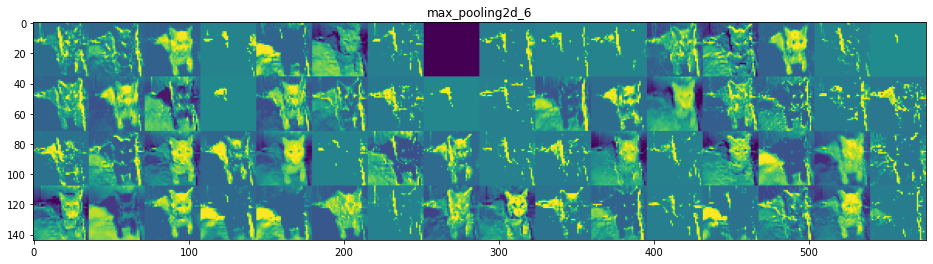

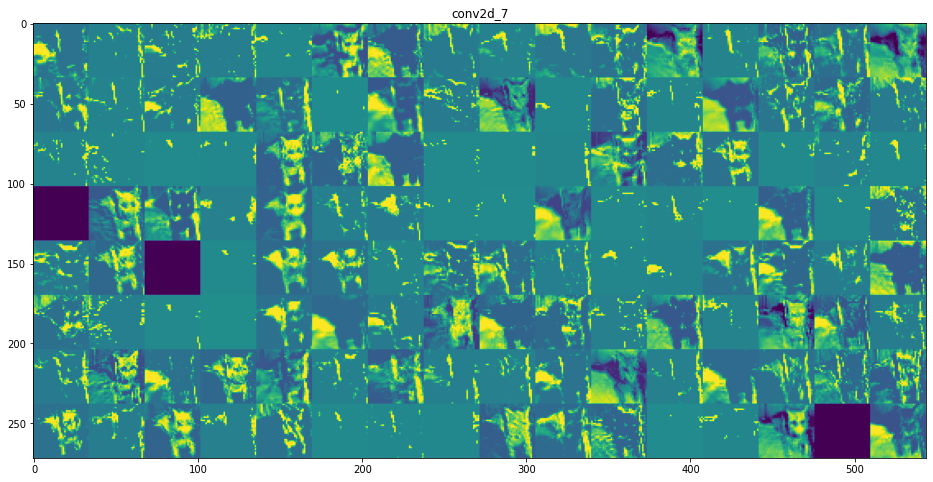

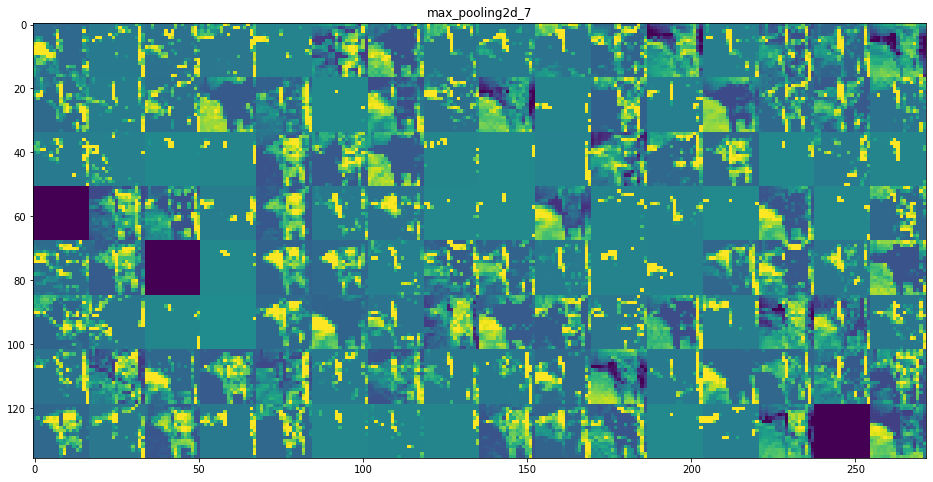

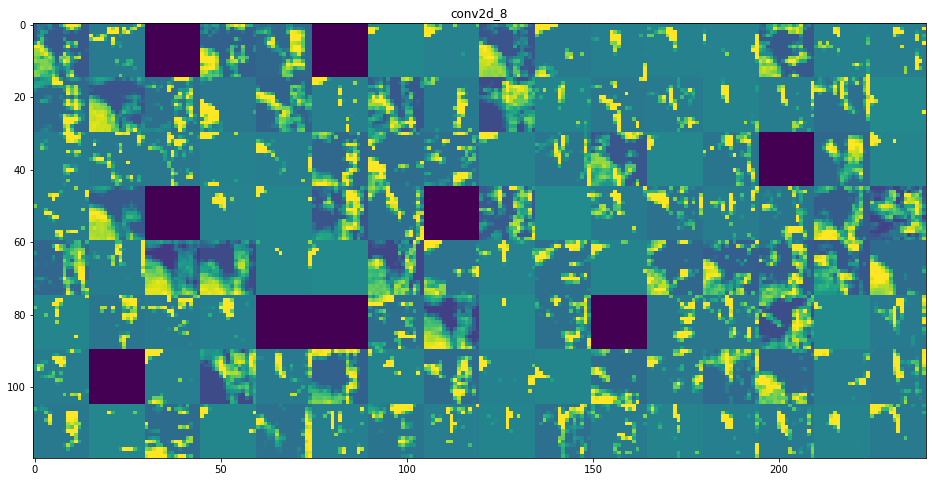

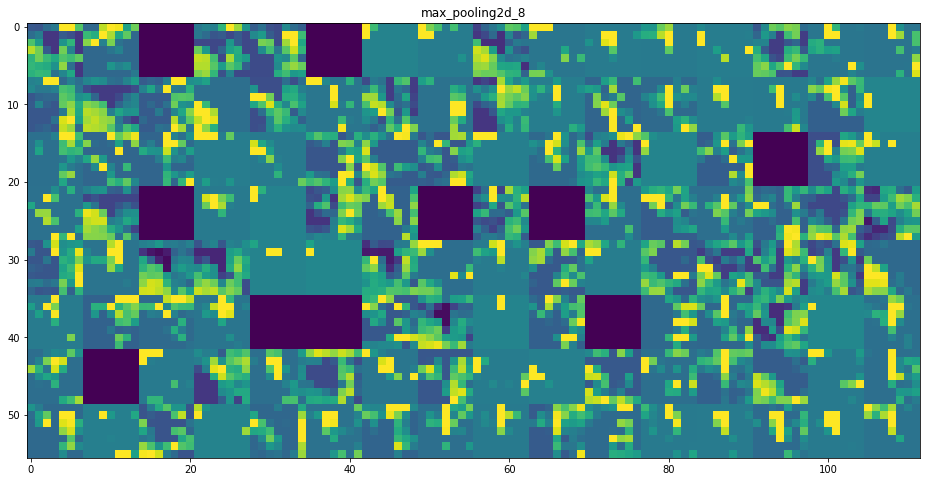

In [12]:
layer_names = []
for layer in model.layers[:8]:
  layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
  n_features = layer_activation.shape[-1]

  size = layer_activation.shape[1]

  n_cols = n_features // images_per_row
  display_grid = np.zeros((size * n_cols, images_per_row * size))

  for col in range(n_cols):
    for row in range(images_per_row):
      channel_image = layer_activation[0,:,:, col * images_per_row + row]
      channel_image -= channel_image.mean()
      channel_image /= channel_image.std()
      channel_image *=64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[col * size : (col + 1) * size,
                   row * size : (row + 1) * size] = channel_image
  
  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1],
                      scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')

Method 2. Visualizing convnet filters

In [1]:
from keras.applications import VGG16
from keras import backend as K
model = VGG16(weights='imagenet',
              include_top=False)
layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

Using TensorFlow backend.


58892288/58889256 [==============================] - 1s 0us/step


In [0]:
grads = K.gradients(loss, model.input)[0]
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

iterate = K.function([model.input], [loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [0]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.
step = 1.
for i in range(40):
  loss_value, grads_value = iterate([input_img_data])
  
  input_img_data += grads_value * step

In [0]:
def deprocess_image(x):
  x -= x.mean()
  x /= (x.std() + 1e-5)
  x *= 0.1
  x += 0.5
  x = np.clip(x, 0, 1)
  x *= 255
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [0]:
def generate_pattern(layer_name, filter_index, size=150):
  layer_output = model.get_layer(layer_name).output
  loss = K.mean(layer_output[:, :, :, filter_index])
  grads = K.gradients(loss, model.input)[0]
  grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
  iterate = K.function([model.input], [loss, grads])
  input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
  step = 1.
  for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step
  img = input_img_data[0]
  return deprocess_image(img)

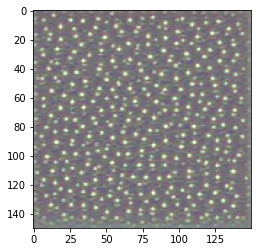

In [7]:
import matplotlib.pyplot as plt
plt.imshow(generate_pattern('block3_conv1',0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


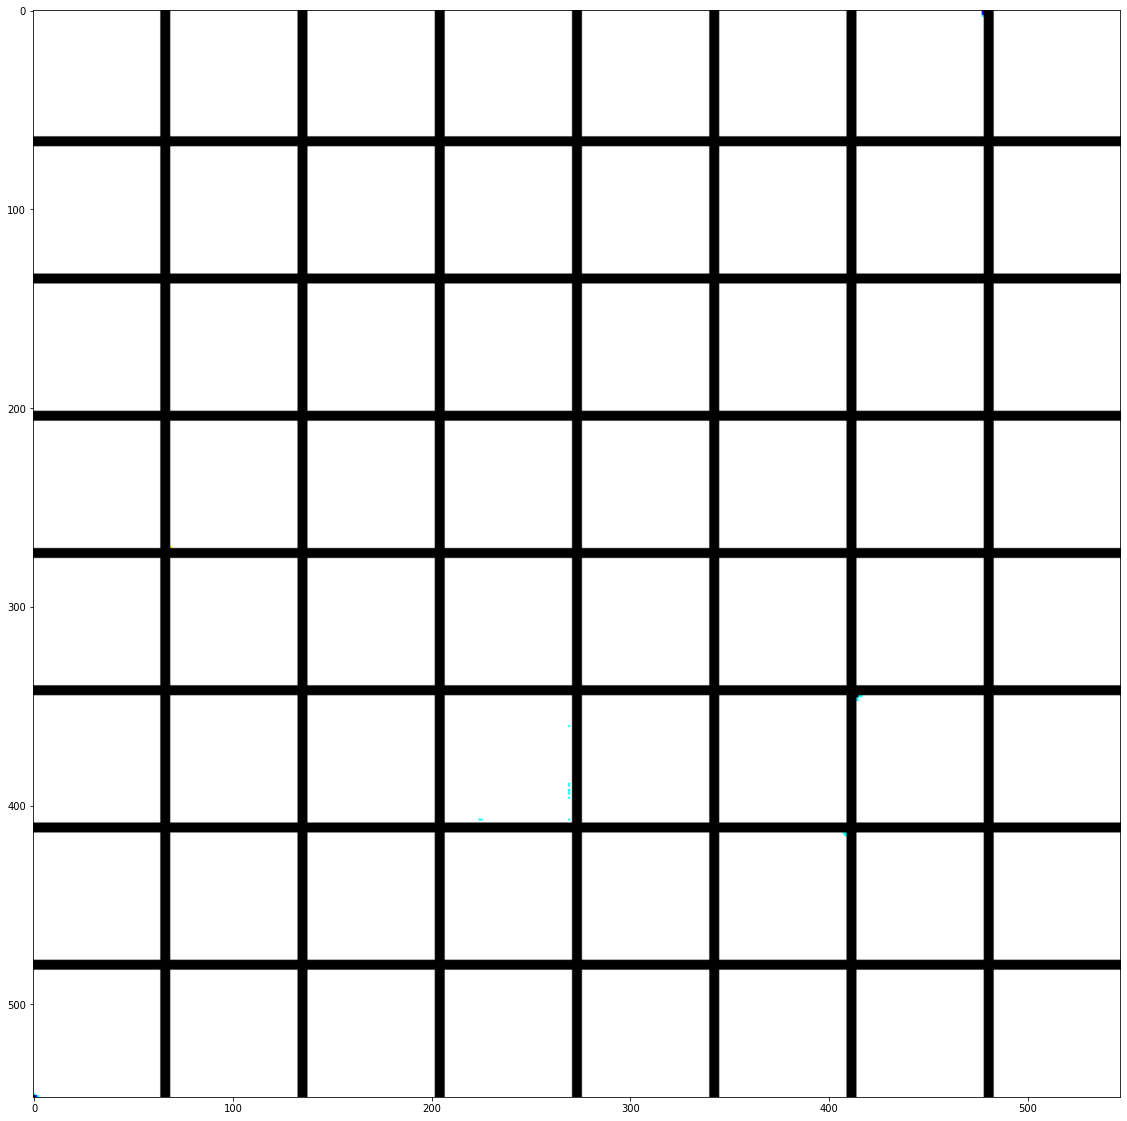

In [11]:
layer_name = 'block1_conv1'
size = 64
margin = 5
results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))
for i in range(8):
  for j in range(8):
    filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
    horizontal_start = i * size + i * margin
    horizontal_end = horizontal_start + size
    vertical_start = j * size + j * margin
    vertical_end = vertical_start + size
    results[horizontal_start: horizontal_end,vertical_start: vertical_end, :] = filter_img
plt.figure(figsize=(20, 20))
plt.imshow(results)